<a href="https://colab.research.google.com/github/sean-metzger/code_examples/blob/master/gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw4/hw4_notebook.ipynb)

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement a GAN model and run it on a dataset. We provide the expected outputs to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [ ]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git 
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 704, done.
remote: Total 704 (delta 0), reused 0 (delta 0), pack-reused 704
Receiving objects: 100% (704/704), 84.47 MiB | 40.70 MiB/s, done.
Resolving deltas: 100% (313/313), done.
Processing ./deepul
  Created wheel for deepul: filename=deepul-0.1.0-cp36-none-any.whl size=12725 sha256=8870a9fed4b61b8d5f5f9489d60a10b73524462f308a8fa64199872dea94dbab
  Stored in directory: /tmp/pip-ephem-wheel-cache-zq8wq1vl/wheels/39/1a/4b/a6f51db275abb2e5dae32540e06ed5011e792f162467bd3aa8
Successfully built deepul
  Found existing installation: deepul 0.1.0
    Uninstalling deepul-0.1.0:
      Successfully uninstalled deepul-0.1.0


In [ ]:
from deepul.hw4_helper import *
import deepul.pytorch_util as ptu
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from scipy.stats import norm
from tqdm import trange, tqdm_notebook

# import deepul_helper.pytorch_util as ptu
# from deepul_helper.data import load_flow_demo_1, generate_1d_flow_data, NumpyDataset
# from deepul_helper.visualize import plot_hist, plot_train_curves, visualize_demo1_flow, plot_demo2_losses
# from deepul_helper.data import load_flow_demo_3, load_flow_demo_2, make_scatterplot

# Question 1: Warmup [20pt]

In this question, we will train 3 different variants of GANs on an easy 1D dataset. 

Execute the cell below to visualize our datasets.

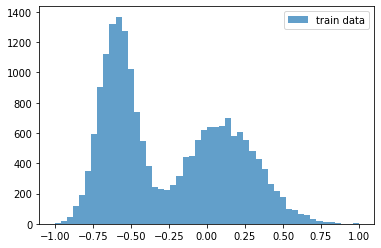

In [ ]:
visualize_q1_dataset()

In [ ]:
def load_q1_data(n=20000):
    assert n % 2 == 0
    gaussian1 = np.random.normal(loc=-1, scale=0.25, size=(n//2,))
    gaussian2 = np.random.normal(loc=0.5, scale=0.5, size=(n//2,))
    data = (np.concatenate([gaussian1, gaussian2]) + 1).reshape([-1, 1])
    scaled_data = (data - np.min(data)) / (np.max(data) - np.min(data) + 1e-8)
    return 2 * scaled_data -1

def load_q2_data(n=20000):
    assert n % 2 == 0
    gaussian1 = np.random.normal(loc=-1, scale=0.03, size=(n//2,))
    gaussian2 = np.random.normal(loc=1, scale=0.03, size=(n//2,))
    data = (np.concatenate([gaussian1, gaussian2]) + 1).reshape([-1, 1])
    scaled_data = (data - np.min(data)) / (np.max(data) - np.min(data) + 1e-8)
    return 2 * scaled_data - 1

def load_warmup_data(n=20000):
    gaussian1 = np.random.normal(loc=-1, scale=0.25, size=(n//2,))
    data = gaussian1.reshape([-1, 1]) + 1
    scaled_data = (data - np.min(data)) / (np.max(data) - np.min(data) + 1e-8)
    return 2 * scaled_data -1

In [ ]:
train_data = load_q1_data()
train_data2 = load_q2_data()
warmup_data = load_warmup_data()

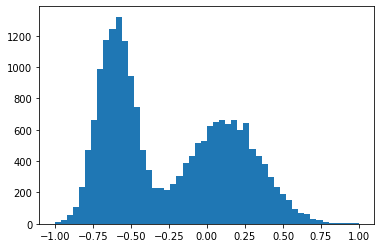

In [ ]:
plt.hist(train_data, bins=50)
plt.show()

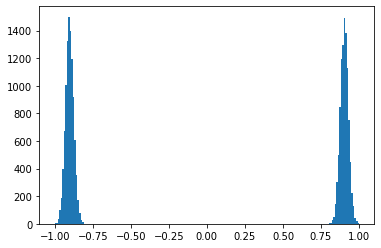

In [ ]:
plt.hist(train_data2, bins=200)
plt.show()

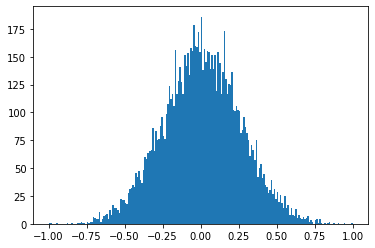

In [ ]:
plt.hist(warmup_data, bins=200)
plt.show()

## Part 1(a)
In this part, we'll train our generator and discriminator via the original minimax GAN objective:
<insert GAN Objective here>
$$min_{G} max_{D} \mathbb{E}_{x \sim p_{data}} [\log D(x)] + \mathbb{E}_{z \sim p(z)}[\log (1-D(G(z)))]$$

Use an MLP for both your generator and your discriminator, and train until the generated distribution resembles the target distribution. 



### Solution

In [ ]:
class generator(nn.Module):
  def __init__(self, in_f, hid_f, out_f=1):
    super(generator, self).__init__()
    self.in_f = in_f
    print('gen, in_f, hidf, outf', in_f, hid_f, out_f)
    self.lay1 = nn.Linear(in_f, hid_f)
    self.lay2 = nn.Linear(hid_f, hid_f)
    self.lay3 = nn.Linear(hid_f, out_f)
    self.lr = nn.LeakyReLU()
    self.hid_shape = in_f

  def forward(self, x):
    x = self.lr(self.lay1(x))
    x = self.lr(self.lay2(x))
    x = self.lay3(x)
    return x

  def generate_samples(self, k): 
    n = torch.randn(k, self.in_f).float().cuda()
    with torch.no_grad(): 
      return(self.forward(n))

class discriminator(nn.Module): 
  
  def __init__(self, hid_f, in_f=1, out_f=1):
    super(discriminator, self).__init__()
    print('disc', 'inf, hidf, outf', in_f, hid_f, out_f)
    self.lay1 = nn.Linear(in_f, hid_f)
    self.lay2 = nn.Linear(hid_f, hid_f)
    self.lay3 = nn.Linear(hid_f, out_f)
    self.lr = nn.LeakyReLU()
  def forward(self, x): 
    x = self.lr(self.lay1(x))
    x = self.lr(self.lay2(x))
    x = F.sigmoid(self.lay3(x))
    return x
  def disc_output(self, x):
    x = x.float().cuda()
    with torch.no_grad():
      return(self.forward(x))

In [ ]:
quiet = False

def train(disc, gen, train_loader, optimizer_disc, optimizer_gen, epoch): 
  disc.train()
  gen.train()
  train_losses = []
  for x in train_loader: 

    x = x.cuda().contiguous()
  
    # Discriminator update. 
    disc.zero_grad()
    n = torch.randn(x.shape[0], gen.hid_shape).float().cuda()
    fakes = gen(n)
    real_disc = disc(x)
    fake_disc = disc(fakes.detach())

    disc_loss = F.binary_cross_entropy(real_disc, torch.ones_like(real_disc).float().cuda())
    disc_loss += F.binary_cross_entropy(fake_disc, torch.zeros_like(fake_disc).float().cuda())
    optimizer_disc.zero_grad()
    disc_loss.backward()
    optimizer_disc.step()
    train_losses.append(disc_loss.item())

    # Generator update
    gen.zero_grad()
    fakes_disc = disc(fakes)
    gen_loss = -1*F.binary_cross_entropy(fakes_disc, torch.zeros_like(fakes_disc).float().cuda())
    optimizer_gen.zero_grad()
    gen_loss.backward()
    optimizer_gen.step()
  return train_losses

def train_epochs(disc, gen, train_loader, train_args, train_losses): 
  epochs, lr = train_args['epochs'], train_args['lr']
  optimizer_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0, 0.9))
  optimizer_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0, 0.9))
  for epoch in range(epochs): 
    gen.train()
    disc.train()
    train_losses.extend(train(disc, gen, train_loader, optimizer_disc, optimizer_gen, epoch))
    print('e', epoch)
  return train_losses

In [ ]:
torch.is_tensor(np.zeros(3))

False

In [ ]:
def post(data):
  if torch.is_tensor(data): 
    a = np.squeeze(data.cpu().detach().numpy())
    print(a.shape)
    return a
  else: 
    return(np.squeeze(a))
  

def q1_a(train_data):
  """
  train_data: An (20000, 1) numpy array of floats in [-1, 1]

  Returns
  - a (# of training iterations,) numpy array of discriminator losses evaluated every minibatch
  - a numpy array of size (5000,) of samples drawn from your model at epoch #1
  - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
  - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid) 
      at each location in the previous array at epoch #1

  - a numpy array of size (5000,) of samples drawn from your model at the end of training
  - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
  - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid) 
      at each location in the previous array at the end of training
  """
  # train_data = torch.tensor(train_data).float()
  # print(train_data.shape)
  train_data = torch.tensor(train_data).float()
  print(train_data.shape)
  train_loader = data.DataLoader(train_data, batch_size=64, shuffle=True)

  # for x in train_loader: 
  #   print(x.shape)

  gen = generator(in_f=10, hid_f=32)
  disc = discriminator(128)
  gen = gen.cuda()
  disc = disc.cuda()

  train_losses = train_epochs(disc, gen, train_loader, dict(epochs=1, lr=1e-4), [])

  e1_samps = gen.generate_samples(5000)
  lin = np.linspace(-1, 1, 1000)
  lint = torch.tensor(np.expand_dims(lin, axis=-1))
  disc_1 = disc.disc_output(lint)


  train_losses = train_epochs(disc, gen, train_loader, dict(epochs=50, lr=1e-4), train_losses)

  ef_samps = gen.generate_samples(5000)
  lin = np.linspace(-1, 1, 1000)
  lint = torch.tensor(np.expand_dims(lin, axis=-1))
  disc_f = disc.disc_output(lint)






  return train_losses, post(e1_samps), lin, post(disc_1), post(ef_samps), lin, post(disc_f)
  
  
  """ YOUR CODE HERE """

In [ ]:
a = np.linspace(-1, 1, 1000)
print(a.shape)

v = np.ones((200, 1))
v = data.DataLoader(v, batch_size=128)
for vv in v: 
  print(vv.shape)

(1000,)
torch.Size([128, 1])
torch.Size([72, 1])


### Results

torch.Size([20000, 1])
gen, in_f, hidf, outf 10 32 1
disc inf, hidf, outf 1 128 1
e 0
e 0
e 1
e 2
e 3
e 4
e 5
e 6
e 7
e 8
e 9
e 10
e 11
e 12
e 13
e 14
e 15
e 16
e 17
e 18
e 19
e 20
e 21
e 22
e 23
e 24
e 25
e 26
e 27
e 28
e 29
e 30
e 31
e 32
e 33
e 34
e 35
e 36
e 37
e 38
e 39
e 40
e 41
e 42
e 43
e 44
e 45
e 46
e 47
e 48
e 49
(5000,)
(1000,)
(5000,)
(1000,)


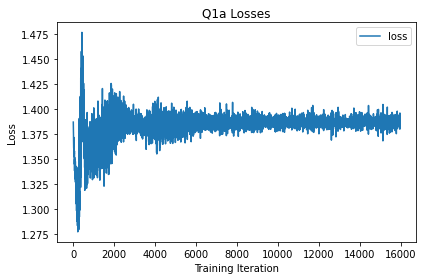

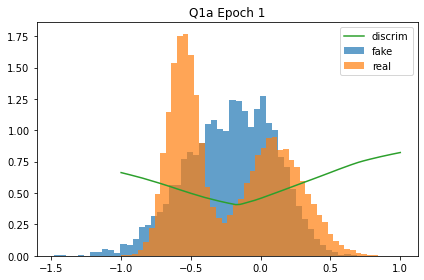

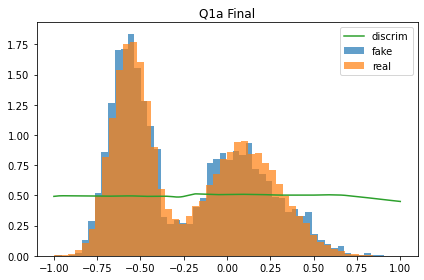

In [ ]:
q1_save_results('a', q1_a)

## Part 1(b)
Here, we'll use the non-saturating formulation of the GAN objective. Now, we have two separate losses:
$$L^{(D)} = \mathbb{E}_{x \sim p_{data}} [\log D(x)] + \mathbb{E}_{z \sim p(z)}[\log (1-D(G(z)))]$$
$$L^{(G} = - \mathbb{E}_{z \sim p(z)} \log(D(G(z))$$

In [ ]:
quiet = False

def train(disc, gen, train_loader, optimizer_disc, optimizer_gen, epoch): 
  disc.train()
  gen.train()
  train_losses = []
  for x in train_loader: 

    x = x.cuda().contiguous()
  
    # Discriminator update. 
    disc.zero_grad()
    n = torch.randn(x.shape[0], gen.hid_shape).float().cuda()
    fakes = gen(n)
    real_disc = disc(x)
    fake_disc = disc(fakes.detach())

    disc_loss = F.binary_cross_entropy(real_disc, torch.ones_like(real_disc).float().cuda())
    disc_loss += F.binary_cross_entropy(fake_disc, torch.zeros_like(fake_disc).float().cuda())
    optimizer_disc.zero_grad()
    disc_loss.backward()
    optimizer_disc.step()
    train_losses.append(disc_loss.item())

    # Generator update
    gen.zero_grad()
    fakes_disc = disc(fakes)
    gen_loss = F.binary_cross_entropy(fakes_disc, torch.ones_like(fakes_disc).float().cuda())
    optimizer_gen.zero_grad()
    gen_loss.backward()
    optimizer_gen.step()
  return train_losses

def train_epochs(disc, gen, train_loader, train_args, train_losses): 
  epochs, lr = train_args['epochs'], train_args['lr']
  optimizer_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0, 0.9))
  optimizer_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0, 0.9))
  for epoch in range(epochs): 
    gen.train()
    disc.train()
    train_losses.extend(train(disc, gen, train_loader, optimizer_disc, optimizer_gen, epoch))
    print('e', epoch)
  return train_losses

 ### Solution

In [ ]:
def q1_b(train_data):
  """
  train_data: An (20000, 1) numpy array of floats in [-1, 1]

  Returns
  - a (# of training iterations,) numpy array of discriminator losses evaluated every minibatch
  - a numpy array of size (5000,) of samples drawn from your model at epoch #1
  - a numpy array of size (100,) linearly spaced from [-1, 1]; hint: np.linspace
  - a numpy array of size (100,), corresponding to the discriminator output (after sigmoid) 
      at each location in the previous array at epoch #1

  - a numpy array of size (5000,) of samples drawn from your model at the end of training
  - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
  - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid) 
      at each location in the previous array at the end of training
  """
  
  """ YOUR CODE HERE """

  train_data = torch.tensor(train_data).float()
  print(train_data.shape)
  train_loader = data.DataLoader(train_data, batch_size=64, shuffle=True)

  # for x in train_loader: 
  #   print(x.shape)

  gen = generator(in_f=10, hid_f=32)
  disc = discriminator(128)
  gen = gen.cuda()
  disc = disc.cuda()

  train_losses = train_epochs(disc, gen, train_loader, dict(epochs=1, lr=1e-4), [])

  e1_samps = gen.generate_samples(5000)
  lin = np.linspace(-1, 1, 1000)
  lint = torch.tensor(np.expand_dims(lin, axis=-1))
  disc_1 = disc.disc_output(lint)


  train_losses = train_epochs(disc, gen, train_loader, dict(epochs=50, lr=1e-4), train_losses)

  ef_samps = gen.generate_samples(5000)
  lin = np.linspace(-1, 1, 1000)
  lint = torch.tensor(np.expand_dims(lin, axis=-1))
  disc_f = disc.disc_output(lint)






  return train_losses, post(e1_samps), lin, post(disc_1), post(ef_samps), lin, post(disc_f)

 ### Results

torch.Size([20000, 1])
gen, in_f, hidf, outf 10 32 1
disc inf, hidf, outf 1 128 1
e 0
e 0
e 1
e 2
e 3
e 4
e 5
e 6
e 7
e 8
e 9
e 10
e 11
e 12
e 13
e 14
e 15
e 16
e 17
e 18
e 19
e 20
e 21
e 22
e 23
e 24
e 25
e 26
e 27
e 28
e 29
e 30
e 31
e 32
e 33
e 34
e 35
e 36
e 37
e 38
e 39
e 40
e 41
e 42
e 43
e 44
e 45
e 46
e 47
e 48
e 49
(5000,)
(1000,)
(5000,)
(1000,)


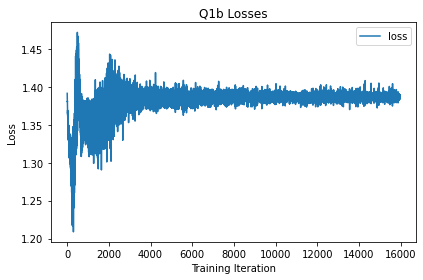

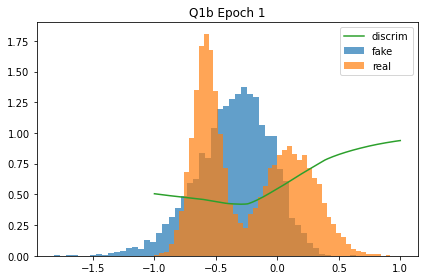

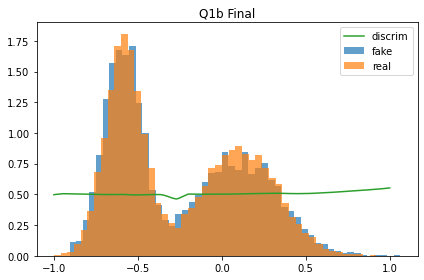

In [ ]:
q1_save_results('b', q1_b)

# Question 2: GANs on CIFAR-10 [35pt]

In this exercise, you will train GANs on CIFAR-10. Execute the cell below to visualize the dataset. 

Extracting ./data/cifar-10-python.tar.gz to ./data


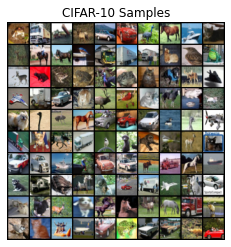

In [ ]:
visualize_q2_data()

 We'll use the CIFAR-10 architecture from the [SN-GAN paper](https://arxiv.org/pdf/1802.05957.pdf), with $z \in \mathbb R ^{128}$, with $z \sim \mathcal N (0, I_{128})$. Instead of upsampling via transposed convolutions and downsampling via pooling or striding, we'll use these DepthToSpace and SpaceToDepth methods for changing the spatial configuration of our hidden states. 

```
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output

# Spatial Upsampling with Nearest Neighbors
Upsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
    x = torch.cat([x, x, x, x], dim=1)
    DepthToSpace(block_size=2)
    Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)


# Spatial Downsampling with Spatial Mean Pooling
Downsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        SpaceToDepth(2)
        torch.sum(x.chunk(4, dim=1)) / 4.0
        nn.Conv2d(in_dim, out_dim, kernel_size,
                              stride=stride, padding=padding, bias=bias)
```

Here's pseudocode for how we'll implement a ResBlockUp, used in the generator:

```
ResnetBlockUp(x, in_dim, kernel_size=(3, 3), n_filters=256):
    _x = x
    _x = nn.BatchNorm2d(in_dim)(_x)
    _x = nn.ReLU()(_x)
    _x = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)(_x)
    _x = nn.BatchNorm2d(n_filters)(_x)
    _x = nn.ReLU()(_x)
    residual = Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)(_x)
    shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)(x)
    return residual + shortcut
```
The ResBlockDown module is similar, except it uses Downsample_Conv2d and omits the BatchNorm.

Finally, here's the architecture for the generator:
```
def Generator(*, n_samples=1024, n_filters=128):
    z = Normal(0, 1)([n_samples, 128])
    nn.Linear(128, 4*4*256)
    reshape output of linear layer
    ResnetBlockUp(in_dim=256, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    nn.BatchNorm2d(n_filters),
    nn.ReLU(),
    nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
    nn.Tanh()
```
Again, the discriminator has the same architecture, except with ResnetBlockDown and no BatchNorm.

**Hyperparameters**

We'll implement [WGAN-GP](https://arxiv.org/abs/1704.00028), which uses a gradient penalty to regularize the discriminator. Use the Adam optimizer with $\alpha = 2e-4$, $\beta_1 = 0$, $\beta_2 = 0.9$, $\lambda = 10$, $n_{critic} = 5$. Use a batch size of 256 and n_filters=128 within the ResBlocks. Train for at least 25000 gradient steps, with the learning rate linearly annealed to 0 over training. 

**You will provide the following deliverables**
1. Inception score (CIFAR-10 version) of the final model. We provide a utility that will automatically do this for you.
2. Fréchet inception distance (bonus, 5pts)
3. Discriminator loss across training
4. 100 samples. 

## Solution

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size # block size = 2
        self.block_size_sq = block_size * block_size
 
    def forward(self, input):
        output = input.contiguous().permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.contiguous().reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.contiguous().split(self.block_size, 3)
        stack = [t_t.contiguous().reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).contiguous().transpose(0, 1).contiguous().permute(0, 2, 1, 3, 4).contiguous().reshape(batch_size, s_height, s_width,
                                                                                      s_depth).contiguous()
        output = output.contiguous().permute(0, 3, 1, 2).contiguous()
        return output
 
 
class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size
 
    def forward(self, input):
        output = input.contiguous().permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.contiguous().split(self.block_size, 2)
        stack = [t_t.contiguous().reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.contiguous().permute(0, 2, 1, 3).contiguous()
        output = output.contiguous().permute(0, 3, 1, 2).contiguous()
        return output
 


In [ ]:
# Spatial Upsampling with Nearest Neighbors

# Upsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
#     x = torch.cat([x, x, x, x], dim=1)
#     DepthToSpace(block_size=2)
#     Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)
class Upsample_Conv2d(nn.Module):
  def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
    super().__init__()
    self.dts = DepthToSpace(block_size=2)
    self.c = nn.Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)
  def forward(self, x): 
    x = torch.cat([x, x, x, x], dim=1) # make hella copies along the channel dim.
    x = self.dts(x) # mean pooling. 
    x = self.c(x)
    return x
 
 
# # Spatial Downsampling with Spatial Mean Pooling
# Downsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
#         SpaceToDepth(2)
#         torch.sum(x.chunk(4, dim=1)) / 4.0
#         nn.Conv2d(in_dim, out_dim, kernel_size,
#                               stride=stride, padding=padding, bias=bias)
class Downsample_Conv2d(nn.Module): 
  def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
    super().__init__()
    self.std = SpaceToDepth(2)
    self.c = nn.Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)
  def forward(self, x):
    x = self.std(x)
    # x = torch.sum(torch.stack(x.chunk(4, dim=1)), dim=0)/4.0
    x = x.contiguous().chunk(4, dim =1)
    x = torch.sum(torch.stack(x), dim=0)
    x = self.c(x)
    return x


In [ ]:
# ResnetBlockUp(x, in_dim, kernel_size=(3, 3), n_filters=256):
#     _x = x
#     _x = nn.BatchNorm2d(in_dim)(_x)
#     _x = nn.ReLU()(_x)
#     _x = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)(_x)
#     _x = nn.BatchNorm2d(n_filters)(_x)
#     _x = nn.ReLU()(_x)
#     residual = Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)(_x)
#     shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)(x)
#     return residual + shortcut
class ResnetBlockUp(nn.Module):
  def __init__(self, in_dim, kernel_size=(3, 3), n_filters=128):
    super().__init__()
    self.bn1 = nn.BatchNorm2d(in_dim)
    self.relu = nn.ReLU()
    self.c = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)
    self.bn2 = nn.BatchNorm2d(n_filters)
    self.r = Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)
    self.sc = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)

  def forward(self, x):
    _x = x
    _x = self.relu(self.bn1(_x))
    _x = self.c(_x)
    _x = self.relu(self.bn2(_x))
    r = self.r(_x)
    sc = self.sc(x)
    return r + sc


# TODO: RESNETBLOCKDOWN.
class ResnetBlockDown(nn.Module):
  def __init__(self, in_dim, kernel_size=(3, 3), n_filters=128):
    super().__init__()
    self.relu = nn.ReLU()
    self.c = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)
    self.r = Downsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)
    self.sc = Downsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)
  def forward(self, x): 
    _x = x
    _x = self.relu(_x)
    _x = self.c(_x)
    _x = self.relu(_x)
    r = self.r(_x)
    sc = self.sc(x)
    return r + sc

In [ ]:
# generator 

# def Generator(*, n_samples=1024, n_filters=128):
#     z = Normal(0, 1)([n_samples, 128])
#     nn.Linear(128, 4*4*256)
#     reshape output of linear layer
#     ResnetBlockUp(in_dim=256, n_filters=n_filters),
#     ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
#     ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
#     nn.BatchNorm2d(n_filters),
#     nn.ReLU(),
#     nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
#     nn.Tanh()

class Generator(nn.Module):
  def __init__(self, n_filters=128):
    super().__init__()
    self.L = nn.Linear(128, 4*4*256)
    # reshape output.
    self.r1 = ResnetBlockUp(in_dim=256, n_filters= n_filters)
    self.r2 = ResnetBlockUp(in_dim =n_filters, n_filters=n_filters)
    self.r3 = ResnetBlockUp(in_dim =n_filters, n_filters=n_filters)
    self.bn = nn.BatchNorm2d(n_filters)
    self.relu = nn.ReLU()
    self.c = nn.Conv2d(n_filters, 3, kernel_size=(3,3), padding=1)

  def forward(self, n_samples): 
    z = torch.randn(n_samples, 128).float().cuda()
    z = self.L(z)
    g = z.contiguous().view(z.shape[0], 256, 4, 4)
    g = self.r1(g)
    g = self.r2(g)
    g = self.r3(g)
    g = self.bn(g)
    g = self.relu(g)
    g = self.c(g)
    g = torch.tanh(g)
    return g

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, n_filters=128):
    # input is a 3x32x32 image. 
    super().__init__()
    self.r1 = ResnetBlockDown(in_dim=3, n_filters=n_filters)
    self.r2 = ResnetBlockDown(in_dim=n_filters, n_filters=n_filters)
    self.r3 = ResnetBlockDown(in_dim=n_filters, n_filters=n_filters)
    self.c = nn.Conv2d(n_filters, n_filters, kernel_size=(3, 3), padding=1)
    self.out = nn.Linear(n_filters, 1)

  def forward(self, x): 
    x = self.r1(x)
    x = self.r2(x)
    x = self.r3(x)
    x = F.relu(x)
    x = self.c(x)
    x = x.contiguous()
    x = torch.mean(x, dim=(2, 3))
    x = self.out(x)
    return x

In [ ]:
x = torch.tensor([0.0, 2.0, 8.0], requires_grad=True)
y = torch.tensor([5.0, 1.0, 7.0], requires_grad=True)
z = x*y
print(z)
z.backward(torch.ones(3))
x.grad.data
y.grad.data

g = nn.Conv2d(3, 3, 3, 1, 1)
i = torch.rand(32, 3, 8, 8)
i.requires_grad = True
z = g(i)
z.backward(torch.ones_like(i))
i.grad.data.shape

In [ ]:
def train(disc, gen, train_loader, optimizer_disc, optimizer_gen, epoch): 
  disc.train()
  gen.train()
  train_losses = []
  lambda_ = 10
  for i, x in enumerate(train_loader): 

    x = x.cuda().contiguous()
  
    # Discriminator update. 
    disc.zero_grad()
    x_tilde = gen(x.shape[0]).contiguous()

    dfakes = disc(x_tilde).mean()
    dreals = disc(x).mean()

    eps = torch.rand(x.shape[0], 1, 1, 1).float().cuda()
    diff = x - x_tilde

    x_hat = eps*x + (1-eps)*x_tilde

    x_hat = x_hat.float().cuda()
    x_hat = torch.autograd.Variable(x_hat, requires_grad=True)
    grad_x_hat = torch.autograd.grad(disc(x_hat), x_hat,
        grad_outputs=torch.ones(x.shape[0], 1).float().cuda(), create_graph=True, 
        retain_graph=True, only_inputs=True)[0]
    grad_x_hat = grad_x_hat.contiguous().view(x.shape[0], -1)
    grad_x_hat = torch.norm(grad_x_hat, p=2, dim=1)
    grad_pen = ((grad_x_hat-1)**2).mean()

    norms = 10*grad_pen
    disc_loss = dfakes - dreals + norms
    optimizer_disc.zero_grad()
    disc_loss.backward()
    optimizer_disc.step()
    train_losses.append(disc_loss.item())
    if i%50 ==0: 
      print(i, disc_loss.item(), 'f, r, n', dfakes.item()-dreals.item(), norms.item())

    if i>0 and i%5 == 0: 
      # Generator update
      # print('updating gen')
      disc.zero_grad()
      gen.zero_grad()
      fakes = gen(256)
      dfakes = disc(fakes)
      gen_loss = torch.mean(-1*dfakes)
      optimizer_gen.zero_grad()
      gen_loss.backward()
      optimizer_gen.step()

  return train_losses
import time
def train_epochs(disc, gen, train_loader, train_args, train_losses): 
  epochs, lr = train_args['epochs'], train_args['lr']
  optimizer_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0, 0.9))
  optimizer_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0, 0.9))

  # Set up LR annealing.
  lr_lambda = lambda epoch: max(0, (1-epoch/130)/min(1, 1-(epoch-1)/130))
  scheduler_D = torch.optim.lr_scheduler.LambdaLR(optimizer_disc, lr_lambda=lr_lambda)
  scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_gen, lr_lambda=lr_lambda)

  train_steps = 0


  for epoch in range(epochs):
    s = time.time() 
    gen.train()
    disc.train()
    train_loss = train(disc, gen, train_loader, optimizer_disc, optimizer_gen, epoch)
    train_losses.extend(train_loss)
    end = time.time()
    print('epoch', epoch, 'time', end-s)
    scheduler_D.step()
    scheduler_G.step()

    if epoch % 3 == 0:
      PATH = '/content/gdrive/My Drive/wggangp.pt'
      torch.save({
          'epoch':epoch,
          'gen_state_dict': gen.state_dict(),
          'gen_optimizer_state_dict': optimizer_gen.state_dict(),
          'disc_state_dict': disc.state_dict(),
          'disc_optimizer_state_dict': optimizer_disc.state_dict(),
          'sched_D_state_dict': scheduler_D.state_dict(),
          'sched_G_state_dict': scheduler_G.state_dict(),
          'train_losses': train_losses} , PATH)
  return train_losses

In [ ]:
def preprocess(data):
  data = (data*2) - 1
  return data

def postprocess(data): 
  data = (data + 1)/2
  return data

In [ ]:
def q2(train_data):
  """
  train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]

  Returns
  - a (# of training iterations,) numpy array of WGAN critic train losses evaluated every minibatch
  - a (1000, 32, 32, 3) numpy array of samples from your model in [0, 1]. 
      The first 100 will be displayed, and the rest will be used to calculate the Inception score. 
  """

  """ YOUR CODE HERE """

  train_data = torch.tensor(train_data).float()
  train_data = preprocess(train_data)

  gen = Generator(128)
  disc = Discriminator(128)
  gen = gen.cuda()
  disc = disc.cuda()

  train_loader = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=True)

  train_losses = train_epochs(disc, gen, train_loader, dict(epochs=130, lr=2e-4), [])

  with torch.no_grad():
    samples = gen(1000).detach().cpu()
    samples = samples.permute(0, 2, 3, 1)
    samples = postprocess(samples)
    samples = samples.numpy()

  return train_losses, samples

    # rescale data
    # toss into WGAN. 
    # Get MONAYYY

## Results

In [ ]:
# a = torch.zeros(32, 3, 8, 8)
# b = torch.ones(32, 3, 8, 8)
# eps = torch.rand(32,1,1,1)
# a + eps*b

# a = torch.ones((64, 512, 16, 16))
# b = a.chunk(4, dim =1)
# torch.sum(torch.stack(b), dim=0).shape

Files already downloaded and verified
0 8.85482120513916 f, r, n -0.022829368710517883 8.877650260925293
50 -9.923990249633789 f, r, n -12.152565002441406 2.228574514389038
100 -8.05286979675293 f, r, n -9.083724021911621 1.0308544635772705
150 -5.009716510772705 f, r, n -5.141075134277344 0.1313585489988327
epoch 0 time 78.5672881603241
0 30.69321632385254 f, r, n 17.071067810058594 13.622148513793945
50 -7.7579216957092285 f, r, n -7.862407684326172 0.1044861227273941
100 -5.675937652587891 f, r, n -7.274410247802734 1.5984728336334229
150 -5.170246601104736 f, r, n -8.311382293701172 3.1411356925964355
epoch 1 time 78.61390113830566
0 2.4655957221984863 f, r, n 1.4076619148254395 1.0579339265823364
50 -8.70842456817627 f, r, n -9.882698059082031 1.1742732524871826
100 -5.167115211486816 f, r, n -5.954963684082031 0.7878482341766357
150 -6.6300201416015625 f, r, n -7.163066864013672 0.5330466032028198
epoch 2 time 78.73285269737244
0 1.590588092803955 f, r, n 0.9230844974517822 0.667

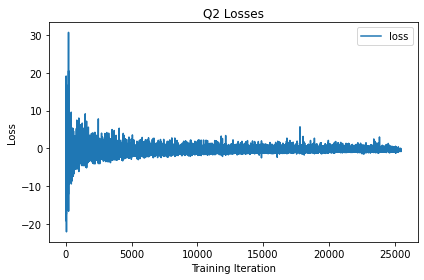

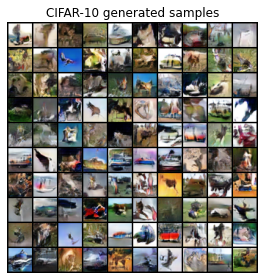

In [ ]:
torch.cuda.empty_cache()
q2_save_results(q2)


In [ ]:
! ls
! cd ./data

# Question 3: Representation Learning with BiGAN on MNIST [45pt]

In this part, we train a BiGAN on the MNIST dataset. Execute the cell below to visualize the dataset.

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!




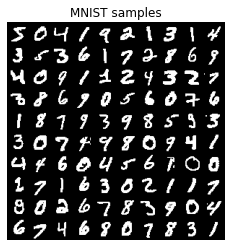

In [ ]:
visualize_q3_data()

In BiGAN, in addition to training a generator $G$ and a discriminator $D$, we train an encoder $E$ that maps from real images $x$ to latent codes $z$. The discriminator now must learn to jointly identify fake $z$, fake $x$, and paired $(x, z)$ that don't belong together. In the original [BiGAN paper](https://arxiv.org/pdf/1605.09782.pdf), they prove that the optimal $E$ learns to invert the generative mapping $G: z \rightarrow x$. Our overall minimax term is now
$$V(D, E, G) = \mathbb{E}_{x \sim p_x}[\mathbb{E}_{z \sim p_E(\cdot | x)}[\log D(x, z)]] + \mathbb{E}_{z \sim p_z}[\mathbb{E}_{x \sim p_G(\cdot | z)}[\log (1 - D(x, z))]]$$

**Architecture**

We will closely follow the MNIST architecture outlined in the original BiGAN paper, Appendix C.1, with one modification: instead of having $z \sim \text{Uniform}[-1, 1]$, we use $z \sim \mathcal N (0, 1)$ with $z \in \mathbb R ^{50}$. 

**Hyperparameters**

We make several modifications to what is listed in the BiGAN paper. We apply $l_2$ weight decay to all weights and decay the step size $\alpha$ linearly to 0 over the course of training. Weights are initialized via the default PyTorch manner. We recommend training for at least 100 epochs -- this part is much less computationally expensive than previous homeworks. 

**Reconstructions**

You should take the first 20 images from the MNIST training set and then display the reconstructions $x_{recon} = G(E(x))$. It's ok if your reconstructions are somewhat lossy; ours are too. We will provide a utility to show these. 

**Testing the representation**

We want to see how good a linear classifier $L$ we can learn such that 
$$y \approx L(E(x))$$
where $y$ is the appropriate label. Fix $E$ and learn a weight matrix $W$ such that your linear classifier is composed of passing $x$ through $E$, then multiplying by $W$, then applying a softmax nonlinearity. Train this via gradient descent with the cross-entropy loss. 

As a baseline, randomly initialize another network $E_{random}$ with the same architecture, fix its weights, and train a linear classifier on top, as done in the previous part.


**You will provide the following deliverables**
1. Plot of the minimax loss term. 
2. 100 samples from the BiGAN
3. A comparison of MNIST images $x$ with their reconstructions $G(E(x))$.
4. Test loss plot for the linear classifier trained on the pretrained encoder, and a randomly initialized encoder. 
5. Final test losses for the two linear classifiers. 

**Feel free to train the networks separately, save the necessary information, and simply use our function to generate the appropriate figures.**


## Solution

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, in_d, out_d):
    super().__init__()
    self.inp = nn.Linear(in_d, 1024)
    self.hid = nn.Linear(1024, 1024)
    self.out = nn.Linear(1024, out_d)
    self.bn = nn.BatchNorm1d(1024, affine=False)
    self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)

  def forward(self, x):
    x = self.leaky_relu(self.inp(x))
    x = self.leaky_relu(self.bn(self.hid(x)))
    x = self.out(x)
    x = F.sigmoid(x)
    return x


class Generator(nn.Module):
  def __init__(self, in_d, out_d): 
    super().__init__()
    self.inp = nn.Linear(in_d, 1024)
    self.hid = nn.Linear(1024, 1024)
    self.out = nn.Linear(1024, out_d)
    self.bn = nn.BatchNorm1d(1024, affine=False)
    self.relu = nn.ReLU()
  def forward(self, x):
    x = self.relu(self.inp(x))
    x = self.relu(self.bn(self.hid(x)))
    x = torch.tanh(self.out(x))
    return x

class Encoder(nn.Module):
  def __init__(self, in_d, out_d):
    super().__init__()
    self.inp = nn.Linear(in_d, 1024)
    self.hid = nn.Linear(1024, 1024)
    self.out = nn.Linear(1024, out_d)
    self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
    self.bn = nn.BatchNorm1d(1024, affine=False)

  def forward(self, x):
    x = self.leaky_relu(self.inp(x))
    x = self.leaky_relu(self.bn(self.hid(x)))
    x = self.out(x)
    return x

In [ ]:
class Classifier(nn.Module): 
  def __init__(self, in_d, out_d, enc):
    super().__init__()
    self.w = nn.Linear(in_d, out_d, bias=False)

    self.enc = enc
    for param in self.enc.parameters():
      param.requires_grad = False
    # self.enc = self.enc # just to make sure. 

  def forward(self, x): 
    self.enc.eval()
    encoding = self.enc(x).detach()
    return self.w(encoding)

In [ ]:
b = torch.ones((16, 784))
a = torch.ones((16, 50))
c = torch.cat((b, a), dim=-1)
print(c.shape)

torch.Size([16, 834])


In [ ]:
def train(disc, gen, enc, train_loader, optimizer_disc, optimizer_gen, optimizer_enc, epoch): 
  disc.train()
  gen.train()
  enc.train()
  train_losses = []
  for x, y in train_loader: 
    x = x.cuda().contiguous()
    x = x.contiguous().view(x.shape[0], -1)

  
    # Discriminator update. 
    disc.zero_grad()
    real_z = torch.randn(x.shape[0], 50).float().cuda()
    fake_z = enc(x)

    real_x = x
    fake_x = gen(real_z)

    fakex_realz = torch.cat((fake_x.detach(), real_z), dim=-1)
    realx_fakez = torch.cat((real_x, fake_z.detach()), dim=-1)

    fakex_realz_disc = disc(fakex_realz)
    realx_fakez_disc = disc(realx_fakez)

    # stack the tensors to feed into the discriminator. 


    disc_loss = F.binary_cross_entropy(realx_fakez_disc, torch.ones_like(realx_fakez_disc).float().cuda())
    disc_loss += F.binary_cross_entropy(fakex_realz_disc, torch.zeros_like(fakex_realz_disc).float().cuda())
    optimizer_disc.zero_grad()
    disc_loss.backward()
    optimizer_disc.step()
    train_losses.append(disc_loss.item())

    # Generator/Encoder update
    gen.zero_grad()
    enc.zero_grad()

    fakex_realz = torch.cat((fake_x, real_z), dim=-1)
    realx_fakez = torch.cat((real_x, fake_z), dim=-1)

    fakex_realz_disc = disc(fakex_realz)
    realx_fakez_disc = disc(realx_fakez)

    

    gen_loss = F.binary_cross_entropy(fakex_realz_disc, torch.ones_like(fakex_realz_disc).float().cuda())
    gen_loss += F.binary_cross_entropy(realx_fakez_disc, torch.zeros_like(realx_fakez_disc).float().cuda())

    optimizer_gen.zero_grad()
    optimizer_enc.zero_grad()
    gen_loss.backward()
    optimizer_gen.step()
    optimizer_enc.step()

  return train_losses
import time
def train_epochs(disc, gen, enc, train_loader, train_args, train_losses=[]): 
  epochs, lr = train_args['epochs'], train_args['lr']
  optimizer_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay = 2.5e-5)
  optimizer_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=2.5e-5)
  optimizer_enc = optim.Adam(enc.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=2.5e-5)

  # Set up LR annealing.
  lr_lambda = lambda epoch: (1-epoch/100)/min(1, 1-(epoch-1)/100)
  scheduler_D = torch.optim.lr_scheduler.LambdaLR(optimizer_disc, lr_lambda=lr_lambda)
  scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_gen, lr_lambda=lr_lambda)
  scheduler_E = torch.optim.lr_scheduler.LambdaLR(optimizer_enc, lr_lambda=lr_lambda)

  for epoch in range(epochs):
    s = time.time() 
    gen.train()
    disc.train()
    enc.train()
    train_loss = train(disc, gen, enc, train_loader, optimizer_disc, optimizer_gen, optimizer_enc, epoch)
    train_losses.extend(train_loss)
    if epoch %5 ==0:
      end = time.time()
      print('epoch', epoch, 'time', end-s)
    scheduler_D.step()
    scheduler_G.step()
    scheduler_E.step()
  
  return train_losses

In [ ]:
n= torch.randn(10, 100)
n = n.argmax(dim=1)
print(n)

tensor([43, 97, 41, 80, 54, 50,  1, 41, 64, 23])


In [ ]:
def train_classifier(model, train_loader, optimizer): 
  model.train()
  train_losses = []
  for x, y in train_loader: 
    x = x.cuda().contiguous().view(x.shape[0], -1)
    pred = model(x)
    loss = F.cross_entropy(pred, y.long().cuda())


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
  return train_losses

def eval_loss(model, test_loader):
  model.eval()
  test_loss = 0
  with torch.no_grad(): 
    total = 0
    correct = 0
    for x, y in test_loader:
      x = x.cuda().contiguous().view(x.shape[0], -1)
      pred = model(x)
      test_loss += F.cross_entropy(pred, y.long().cuda())*x.shape[0]
      _, predicted = torch.max(pred.data, 1)
      correct += (predicted.cuda() == y.cuda()).sum().item()
      total += y.shape[0]
    avg_loss = test_loss/len(test_loader.dataset)
    avg_acc = correct/total
    print('avg acc', avg_acc)
    print('avg loss', avg_loss.item())
    
    
  return avg_loss.item()



def train_classifier_epochs(classifier, train_loader, test_loader, train_args): 
  epochs, lr = train_args['epochs'], train_args['lr']
  optimizer = optim.Adam(classifier.parameters(), lr=lr)
  train_losses = []
  test_losses = []
  for epoch in range(epochs):
    train_loss = train_classifier(classifier, train_loader, optimizer)
    train_losses.extend(train_loss)
    test_loss = eval_loss(classifier, test_loader)
    test_losses.append(test_loss)
    print(f'Epoch {epoch}, Test loss', test_loss)
  return test_losses

In [ ]:
def q3(train_data, test_data):
  """
  train_data: A PyTorch dataset that contains (n_train, 28, 28) MNIST digits, normalized to [-1, 1]
              Documentation can be found at torchvision.datasets.MNIST, and it may be easiest to directly create a DataLoader from this variable
  test_data: A PyTorch dataset that contains (n_test, 28, 28) MNIST digits, normalized to [-1, 1]
              Documentation can be found at torchvision.datasets.MNIST

  Returns
  - a (# of training iterations,) numpy array of BiGAN minimax losses evaluated every minibatch
  - a (100, 28, 28, 1) numpy array of BiGAN samples that lie in [0, 1]
  - a (40, 28, 28, 1) numpy array of 20 real image / reconstruction pairs
  - a (# of training epochs,) numpy array of supervised cross-entropy losses on the BiGAN encoder evaluated every epoch 
  - a (# of training epochs,) numpy array of supervised cross-entropy losses on a random encoder evaluated every epoch 
  """

  """ YOUR CODE HERE """


  train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=True)




  gen = Generator(50, 784)
  disc = Discriminator(784+50, 1)
  enc = Encoder(784, 50)
  gen = gen.cuda()
  disc = disc.cuda()
  enc = enc.cuda()
  train_losses = train_epochs(disc, gen, enc, train_loader, dict(epochs=100, lr=2e-4))

  # Samples, 100 samples. 
  n = torch.randn(100, 50).float().cuda()
  with torch.no_grad(): 
    samps = gen(n).detach().cpu()
  samps = samps.view(100, 28, 28, 1)
  samps = (samps + 1)/2
  samps = samps.numpy()

  # Pairs. 
  for x, y in test_loader: 
    x = x[:20]
    break
  print(x.shape)
  x = x.view(x.shape[0], -1).float().cuda()
  print(x.shape)
  with torch.no_grad(): 
    gen.eval()
    enc.eval()
    recon = gen(enc(x)).cpu()
    print(recon.shape)
    recon = recon.view(20, 28, 28, 1)
    orig = x.view(20, 28, 28, 1).cpu()
    pairs = torch.cat((recon, orig), dim=0)
    pairs = (pairs + 1)/2
    pairs = pairs.numpy()

  trash_encoder = Encoder(784, 50)
  trash_classifier = Classifier(50, 10, trash_encoder).cuda()
  trash_losses = train_classifier_epochs(trash_classifier, train_loader, test_loader, dict(epochs=50, lr=1e-3))

  good_classifier = Classifier(50, 10, enc).cuda()
  good_losses = train_classifier_epochs(good_classifier, train_loader, test_loader, dict(epochs=50, lr=1e-3))

  return train_losses, samps, pairs, good_losses, trash_losses


## Results

epoch 0 time 10.165614604949951
epoch 5 time 9.98638129234314
epoch 10 time 9.883986473083496
epoch 15 time 9.818946838378906
epoch 20 time 9.819012880325317
epoch 25 time 10.020322799682617
epoch 30 time 9.91168475151062
epoch 35 time 9.772693872451782
epoch 40 time 9.830212354660034
epoch 45 time 9.75250792503357
epoch 50 time 9.85382628440857
epoch 55 time 9.80913233757019
epoch 60 time 9.851539611816406
epoch 65 time 9.755615472793579
epoch 70 time 9.694181680679321
epoch 75 time 9.770196676254272
epoch 80 time 9.659215688705444
epoch 85 time 9.832149028778076
epoch 90 time 9.961560010910034
epoch 95 time 9.831198453903198
torch.Size([20, 1, 28, 28])
torch.Size([20, 784])
torch.Size([20, 784])
avg acc 0.6006
avg loss 2.0630764961242676
Epoch 0, Test loss 2.0630764961242676
avg acc 0.6733
avg loss 1.8611865043640137
Epoch 1, Test loss 1.8611865043640137
avg acc 0.702
avg loss 1.693532943725586
Epoch 2, Test loss 1.693532943725586
avg acc 0.7122
avg loss 1.5537060499191284
Epoch 3, T

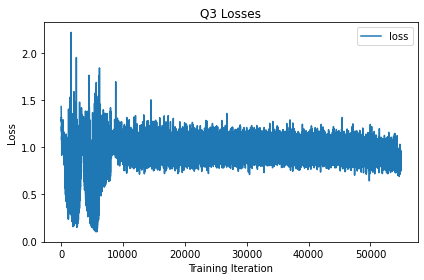

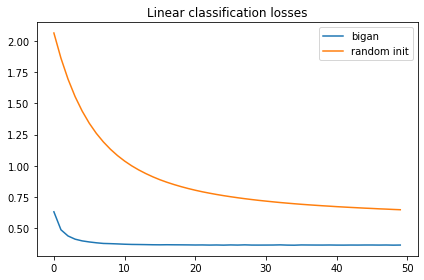

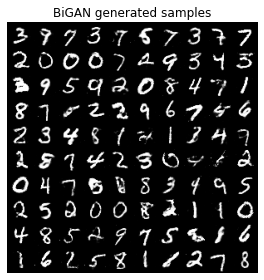

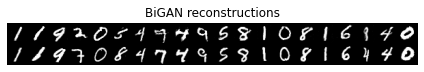

BiGAN final linear classification loss: 0.3645372986793518
Random encoder linear classification loss: 0.6474475860595703


In [ ]:
q3_save_results(q3)

# Question 4 (Bonus): CycleGAN [20pt]
In this question, you'll train a CycleGAN model to learn to translate between two different image domains, without any paired data. Execute the following cell to visualize our two datasets: MNIST and Colored MNIST. 

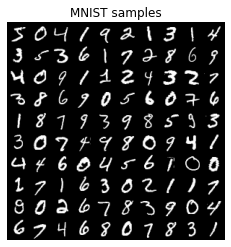

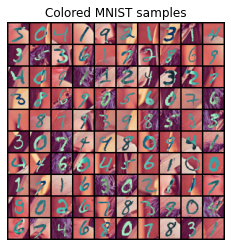

In [ ]:
visualize_cyclegan_datasets()

In [CycleGAN](https://arxiv.org/pdf/1703.10593.pdf), the goal is to learn functions $F$ and $G$ that can transform images from $X \rightarrow Y$ and vice-versa. This is an unconstrained problem, so we additionally enforce the *cycle-consistency* property, where we want 
$$x \approx G(F(x))$$
and  
$$y \approx F(G(x))$$
This loss function encourages $F$ and $G$ to approximately invert each other. In addition to this cycle-consistency loss, we also have a standard GAN loss such that $F(x)$ and $G(y)$ look like real images from the other domain. 

Since this is a bonus question, we won't do much hand-holding. We recommend reading through the original paper to get a sense of what architectures and hyperparameters are useful. Note that our datasets are fairly simple, so you won't need excessively large models. 

**You will report the following deliverables**
1. A set of images showing real MNIST digits, transformations of those images into Colored MNIST digits, and reconstructions back into the greyscale domain. 
2. A set of images showing real Colored MNIST digits, transformations of those images, and reconstructions. 

## Solution

In [ ]:
class ResBlock(nn.Module):
  def __init__(self, num_channels): 
    super().__init__()
    self.conv1 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
    self.relu = nn.ReLU()
    self.in1 = nn.InstanceNorm2d(num_channels)
    self.in2 = nn.InstanceNorm2d(num_channels)

  def forward(self, x): 
    x_ = x
    x_ = self.relu(self.in1(self.conv1(x_)))
    x_ = self.relu(self.in2(self.conv2(x_)))
    return x_ + x


In [ ]:
class CycleGen(nn.Module): 
  def __init__(self, chan_in, chan_out):
    super().__init__()
    self.inc = nn.Conv2d(chan_in,64, 3, stride=1, padding=1)
    self.c2 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
    self.inorm_2 = nn.InstanceNorm2d(64)
    self.relu = nn.ReLU()


    self.c3 = nn.Conv2d(128, 128, 3, stride=2, padding=1)
    self.inorm_3 = nn.InstanceNorm2d(128)
    # Going to keep it at 128 because we're only doing MNIST.
    self.r1 = ResBlock(128)
    # self.r2 = ResBlock(128)
    # self.r3 = ResBlock(128)

    # Now we go back down into our og space. 
    self.dc1 = nn.ConvTranspose2d(128, 128, 3, stride=2, padding=1, output_padding=1)
    self.inorm_out1 = nn.InstanceNorm2d(128)
    self.dc2  = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)
    self.inorm_out2 = nn.InstanceNorm2d(64)
    self.out = nn.Conv2d(64, chan_out, 7, stride=1, padding=3)

  def forward(self, x): 
    x = self.inc(x) 
    x = self.relu(self.inorm_2(self.c2(x)))
    x = self.relu(self.inorm_3(self.c3(x)))
    x = self.r1(x)
    # x = self.r2(x)
    # x = self.r3(x)
    x = self.relu(self.inorm_out1(self.dc1(x)))
    x = self.relu(self.inorm_out2(self.dc2(x)))
    x = self.out(x)
    return torch.tanh(x)



In [ ]:
class CycleDisc(nn.Module):
  def __init__(self, chan_in): 
    super().__init__()
    self.conv1 = nn.Conv2d(chan_in, 32, 4, stride=2, padding=1) #28x28

    self.lkr = nn.LeakyReLU(0.2)
    self.conv2 = nn.Conv2d(32, 64, 4, 2, 1) #14, 14
    self.bn2 = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(64, 128, 4, 2, 1) #7 x 7
    self.bn3 = nn.BatchNorm2d(128)
    self.convout = nn.Conv2d(128, 1, kernel_size=4, stride=1, padding=1) # 6 x 6 PATCHGAN

  def forward(self, x): 
    x = self.lkr(self.conv1(x))
    x = self.lkr(self.bn2(self.conv2(x)))
    x = self.lkr(self.bn3(self.conv3(x)))
    x = self.convout(x)
    return F.sigmoid(x) 



In [ ]:
if True: 
  a= torch.ones(3, 3)
  z = [0]
  b= a[z]
  a[z] = torch.zeros(1, 3)
print(b)

tensor([[1., 1., 1.]])


In [ ]:
def train(discX, discY, genF, genG, train_loaderX, train_loaderY, optimizer_discX, optimizer_genF, optimizer_discY, optimizer_genG, image_buff_genF, image_buff_genG): 
  print('starting tr')
  # TODO: Image buffer w previous 50 images to reduce oscillation. 
  discY.train()
  genF.train()
  discX.train()
  genG.train()
  train_losses = []
  bc = 0

  mse = nn.MSELoss()
  l1 = nn.L1Loss()
  for x, y in zip(train_loaderX, train_loaderY): 
    # count number of batches. 
    bc+=1
    if bc%100 ==0: 
      print(bc, image_buff_genF.shape)
    
    x = x.cuda().contiguous()
    y = y.cuda().contiguous()

    # Discriminator update. 
    discX.zero_grad()

    faux_x = genF(y)
    faux_y = genG(x)

    # deal with image buffers. 
    if image_buff_genF == None: 
      image_buff_genF = faux_x.detach()
      image_buff_genG = faux_y.detach()
      #Initialize it to that. 
      sample_faux_x = image_buff_genF
      sample_faux_y = image_buff_genG

    elif image_buff_genF.shape[0] < 256: 
      image_buff_genF = torch.cat((image_buff_genF, faux_x.detach()), dim=0)
      image_buff_genG = torch.cat((image_buff_genG, faux_y.detach()), dim=0)
      # Otherwise add the new images to the image buffer. 
      sample_faux_x = image_buff_genF
      sample_faux_y = image_buff_genG
    
    elif image_buff_genF.shape[0] >= 256: 
      # we're going to randomly take half the batch. 
      ind_1 = np.random.permutation(faux_x.shape[0])
      ind_1_1 = ind_1[:faux_x.shape[0]//2]
      half_batch_fx = faux_x.detach()[ind_1_1]
      half_batch_fy = faux_y.detach()[ind_1_1]

      # sample that many from the buff. 
      ind = np.random.permutation(image_buff_genF.shape[0])[:faux_x.shape[0]//2]
      half_batch_buff_fx = image_buff_genF[ind]
      half_batch_buff_fy = image_buff_genG[ind]
    
      # add those samples to make what we're putting into the discrim. 
      sample_faux_x = torch.cat((half_batch_fx, half_batch_buff_fx), dim=0)
      sample_faux_y = torch.cat((half_batch_fy, half_batch_buff_fy), dim=0)

      # replace all those images from the buffer with ones that werent used. 
      ind_1_2 = ind_1[faux_x.shape[0]//2:]
      image_buff_genF[ind] = faux_x.detach()[ind_1_2]
      image_buff_genG[ind] = faux_y.detach()[ind_1_2]

      

    # image_buff_genF = faux_x.detach()
    # image_buff_genG = faux_y.detach()

    discX_fake_outs = discX(sample_faux_x) # stabilized. 
    discX_real_outs = discX(x) # stable. 

    discY.zero_grad()
    discY_fake_outs = discY(sample_faux_y)
    discY_real_outs = discY(y)

    # TODO: replace with l2 loss. 
    discX_loss = mse(discX_real_outs, torch.ones_like(discX_real_outs).float().cuda())
    discX_loss += mse(discX_fake_outs, torch.zeros_like(discX_fake_outs).float().cuda())
    discX_loss = discX_loss/2 # from the paper.
    
    discY_loss = mse(discY_real_outs, torch.ones_like(discY_real_outs).float().cuda())
    discY_loss += mse(discY_fake_outs, torch.zeros_like(discY_fake_outs).float().cuda())
    discY_loss = discY_loss/2 # from the paper. 

    optimizer_discX.zero_grad()
    discX_loss.backward()
    optimizer_discX.step()

    optimizer_discY.zero_grad()
    discY_loss.backward()
    optimizer_discY.step()

    # Generator Adversarial Update. 
    genF.zero_grad()
    genG.zero_grad()

    # Try to trick the discriminator. 
    foolX = discX(faux_x)
    foolY = discY(faux_y)

    genF_loss = F.mse_loss(foolX, torch.ones_like(foolX).float().cuda())
    genG_loss = F.mse_loss(foolY, torch.ones_like(foolY).float().cuda())

    recon_x = genF(faux_y)
    recon_y = genG(faux_x)

    x = x.contiguous().view(x.shape[0], -1)
    recon_x = recon_x.contiguous().view(recon_x.shape[0], -1)
    y = y.contiguous().view(y.shape[0], -1)
    recon_y = recon_y.contiguous().view(recon_y.shape[0], -1)

    l1x = l1(x, recon_x)
    l1y = l1(y, recon_y)
    l1y = l1y.mean()

    gen_loss = genF_loss + genG_loss + 10*(l1x + l1y)

    optimizer_genF.zero_grad()
    optimizer_genG.zero_grad()
    gen_loss.backward()
    optimizer_genF.step()
    optimizer_genG.step()

  return train_losses, image_buff_genF, image_buff_genG

In [ ]:
def lr_lambda(epoch):
    if epoch < 16: 
      lr_l = 1.0
    else: 
      d = min(1, epoch-16)
      lr_lambda = lambda epoch: max(0, (1-d/16)/min(1, 1-(d-1)/16))
    return lr_l

In [ ]:
import time
def train_epochs(discX, discY, genF, genG, train_loaderX, train_loaderY, train_args, train_losses=[]): 
  epochs, lr = train_args['epochs'], train_args['lr']

  # Optimizer SQUAD. 
  optimizer_discX = optim.Adam(discX.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay = 2.5e-5)
  optimizer_discY = optim.Adam(discY.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay = 2.5e-5)
  optimizer_genF = optim.Adam(genF.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=2.5e-5)
  optimizer_genG = optim.Adam(genG.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=2.5e-5)

  # Set up LR annealing.
  lr_lambda = lambda epoch: max(0, (1-max(0, (epoch-16)/32))/min(1, 1-max(0, (epoch-17)/32)))
  scheduler_dX = torch.optim.lr_scheduler.LambdaLR(optimizer_discX, lr_lambda=lr_lambda)
  scheduler_dY = torch.optim.lr_scheduler.LambdaLR(optimizer_discY, lr_lambda=lr_lambda)
  scheduler_gG = torch.optim.lr_scheduler.LambdaLR(optimizer_genG, lr_lambda=lr_lambda)
  scheduler_gF = torch.optim.lr_scheduler.LambdaLR(optimizer_genF, lr_lambda=lr_lambda)

  #initialize image BUFFS. 
  image_buff_genF = None
  image_buff_genG = None


  for epoch in range(epochs):
  
    s = time.time() 
    genF.train()
    discX.train()
    genG.train()
    discY.train()
    train_loss, image_buff_genF, image_buff_genG = train(discX, discY, genF, genG, train_loaderX, train_loaderY, 
                       optimizer_discX, optimizer_genF, optimizer_discY, optimizer_genG,
                       image_buff_genF, image_buff_genG)
    train_losses.extend(train_loss)
    if epoch %1 ==0:
      end = time.time()
      print('epoch', epoch, 'time', end-s)
    scheduler_dX.step()
    scheduler_dY.step()
    scheduler_gG.step()
    scheduler_gF.step()
  
  return train_losses

In [ ]:
def preprocess(data): 
  data = torch.tensor(data).float()
  # data = data.permute(0, 3, 1, 2) # channels ready for our network
  data = data*2 -1
  return data

def postprocess(data):
  data = (data + 1)/2
  data = data.permute(0, 2,3,1)
  data = data.numpy()
  return data # channels at end. 

In [ ]:
def q4(mnist_data, cmnist_data):
  """
  mnist_data: An (60000, 1, 28, 28) numpy array of black and white images with values in [0, 1]
  cmnist_data: An (60000, 3, 28, 28) numpy array of colored images with values in [0, 1]

  
  Returns
  - a (20, 28, 28, 1) numpy array of real MNIST digits, in [0, 1]
  - a (20, 28, 28, 3) numpy array of translated Colored MNIST digits, in [0, 1]
  - a (20, 28, 28, 1) numpy array of reconstructed MNIST digits, in [0, 1]

  - a (20, 28, 28, 3) numpy array of real Colored MNIST digits, in [0, 1]
  - a (20, 28, 28, 1) numpy array of translated MNIST digits, in [0, 1]
  - a (20, 28, 28, 3) numpy array of reconstructed Colored MNIST digits, in [0, 1]
  """
  """ YOUR CODE HERE """
  mnist_data = preprocess(mnist_data)
  cmnist_data = preprocess(cmnist_data)

  mnist_data_tr = mnist_data[:-20]
  cmnist_data_tr = cmnist_data[:-20]

  mnist_data_te = mnist_data[-20:]
  cmnist_data_te = cmnist_data[-20:]

  """
  ok for reference: 
  X = MNIST BW 
  Y = CMNIST. 

  F = map from y to x
  G = map from x to y

  """
  discX = CycleDisc(1)
  discY = CycleDisc(3)

  genF = CycleGen(3, 1)
  genG = CycleGen(1, 3)

  discX = discX.cuda()
  discY = discY.cuda()
  genF = genF.cuda()
  genG = genG.cuda()

  train_loaderX = torch.utils.data.DataLoader(mnist_data_tr, batch_size=128, shuffle=True)
  train_loaderY = torch.utils.data.DataLoader(cmnist_data_tr, batch_size=128, shuffle=True)

  train_losses = train_epochs(discX, discY, genF, genG, train_loaderX, train_loaderY, dict(epochs=32, lr=2e-4))
  # Returns
  # - a (20, 28, 28, 1) numpy array of real MNIST digits, in [0, 1]
  # - a (20, 28, 28, 3) numpy array of translated Colored MNIST digits, in [0, 1]
  # - a (20, 28, 28, 1) numpy array of reconstructed MNIST digits, in [0, 1]

  # - a (20, 28, 28, 3) numpy array of real Colored MNIST digits, in [0, 1]
  # - a (20, 28, 28, 1) numpy array of translated MNIST digits, in [0, 1]
  # - a (20, 28, 28, 3) numpy array of reconstructed Colored MNIST digits, in [0, 1]
  
  real_MNIST = postprocess(mnist_data_te)
  genG.eval()
  genF.eval()
  with torch.no_grad(): 
    translated_color = genG(mnist_data_te.float().cuda())
    reconstructed = genF(translated_color).detach().cpu()
    translated_color = postprocess(translated_color.cpu())
    reconstructed = postprocess(reconstructed)

  real_C_mnist = postprocess(cmnist_data_te)
  with torch.no_grad():
    translated_normal = genF(cmnist_data_te.float().cuda())
    reconstructed_C = genG(translated_normal).cpu()
    translated_normal = postprocess(translated_normal.cpu())
    reconstructed_C = postprocess(reconstructed_C)
  
  return real_MNIST, translated_color, reconstructed, real_C_mnist, translated_normal, reconstructed_C

  

## Results

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz
starting tr
100 torch.Size([256, 1, 28, 28])
200 torch.Size([256, 1, 28, 28])
300 torch.Size([256, 1, 28, 28])
400 torch.Size([256, 1, 28, 28])
epoch 0 time 95.25259637832642
starting tr
100 torch.Size([256, 1, 28, 28])
200 torch.Size([256, 1, 28, 28])
300 torch.Size([256, 1, 28, 28])
400 torch.Size([256, 1, 28, 28])
epoch 1 time 95.19984030723572
starting tr
100 torch.Size([256, 1, 28, 28])
200 torch.Size([256, 1, 28, 28])
300 torch.Size([256, 1, 28, 28])
400 torch.Size([256, 1, 28, 28])
epoch 2 time 94.95361161231995
starting tr
100 torch.Size([256, 1, 28, 28])
200 torch.Size([256, 1, 28, 28])
300 torch.Size([256, 1, 28, 28])
400 torch.Size([256, 1, 28, 28])
epoch 3 time 94.92947173118591
starting tr
100 torch.Size([256, 1, 28, 28])
200 torch.Size([256, 1, 28, 28])
300 torch.Size([256, 1, 28, 28])
400 torch.Size(

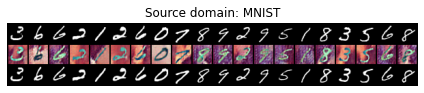

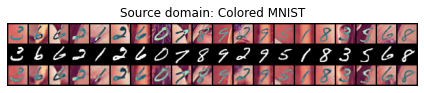

In [ ]:
q4_save_results(q4)